# CNN Cancer Detection Project

## Table of Contents
- [Introduction](#Introduction)
- [Dependencies](#Dependencies)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Model Architecture](#Model-Architecture)
- [Results and Analysis](#Results-and-Analysis)
- [Conclusion](#Conclusion)

## Introduction

The project aims to train a convolutional neural network to determine whether a given image of body tissue, obtained from a pathology scan, indicates the presence of cancer. It's a binary classification challenge where each sample is tagged either as cancerous (1) or non-cancerous (0). Here, "cancerous" denotes that at least one pixel in the image shows tumorous tissue.

### Source

Data for this project is sourced from the Kaggle competition: [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection).

### Training Data
- **Number of Images:** 220,025
- **Labeling:** Each image is labeled as cancerous (1) or non-cancerous (0).

### Test Data
- **Number of Images:** 57,458
- **Labeling:** The test images are unlabeled. 

## Dependencies

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import gc
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import imageio
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


## Exploratory Data Analysis

In [4]:
inputdir = os.listdir('/kaggle/input/')
print(inputdir)

datadir = f'/kaggle/input/{inputdir[0]}'
print(datadir)

['histopathologic-cancer-detection']
/kaggle/input/histopathologic-cancer-detection


### Distribution of classes

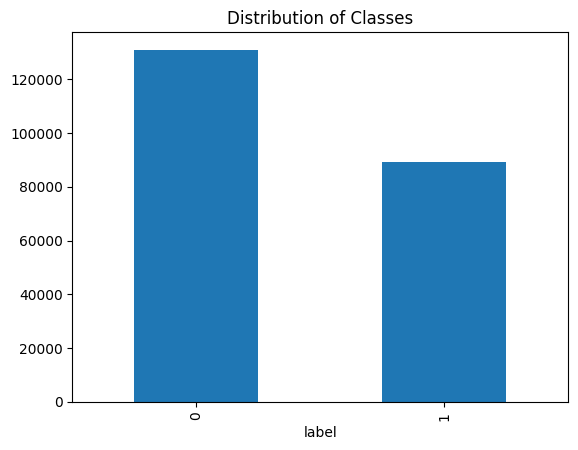

In [5]:
labels_df = pd.read_csv(f'{datadir}/train_labels.csv')

labels_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Classes')
plt.show()

### Sample Images and Dimensions

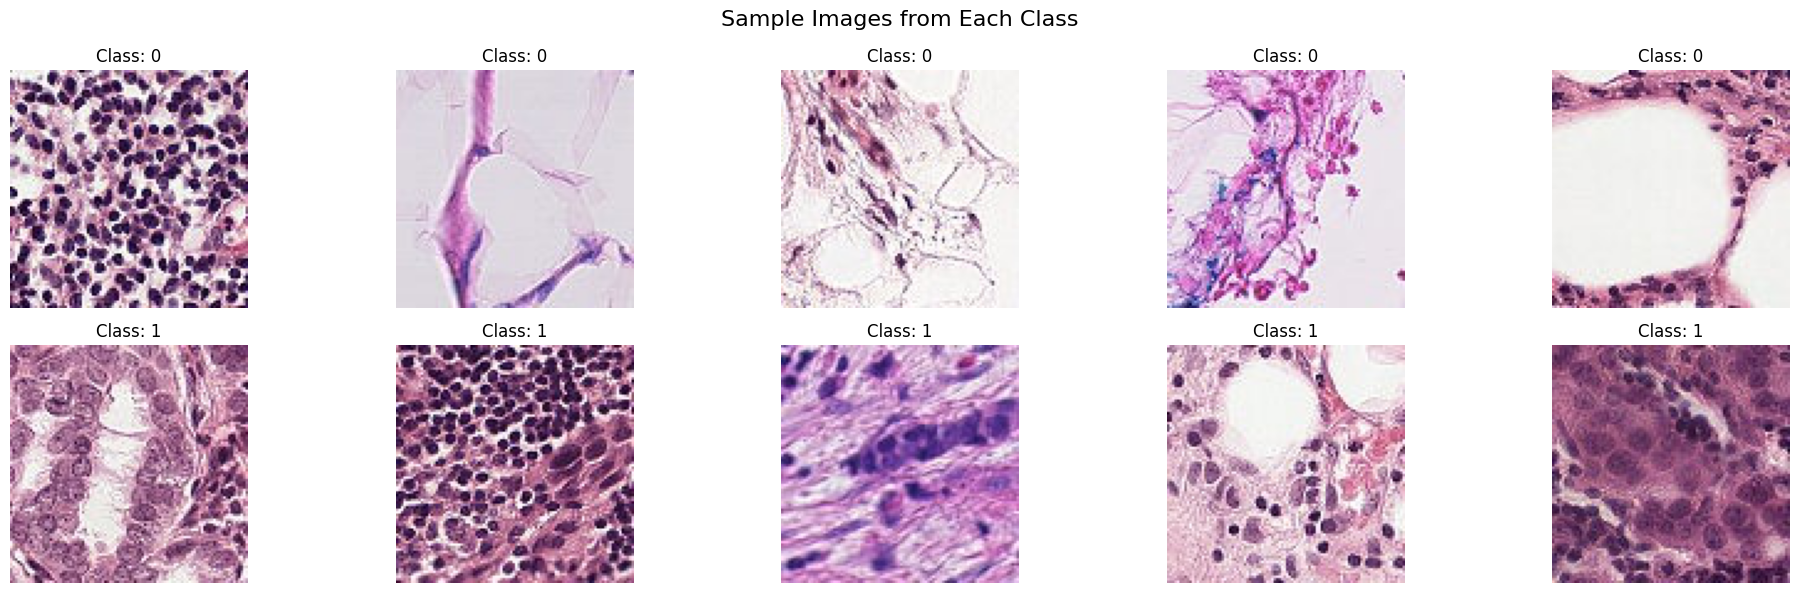

Image Dimensions: (96, 96, 3)


In [6]:
fig, ax = plt.subplots(2, 5, figsize=(20, 6))
fig.suptitle('Sample Images from Each Class', fontsize=16)


for i, label in enumerate([0, 1]):
    sample_images = labels_df[labels_df['label'] == label].sample(5)['id'].values
    for j, image_id in enumerate(sample_images):
        img_path = os.path.join(datadir, 'train', f"{image_id}.tif")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        ax[i, j].imshow(img)
        ax[i, j].set_title(f"Class: {label}")
        ax[i, j].axis('off')

plt.tight_layout()
plt.show()

sample_image_path = os.path.join(datadir, 'train', f"{labels_df['id'].iloc[0]}.tif")
sample_image = cv2.imread(sample_image_path)
print(f"Image Dimensions: {sample_image.shape}")

We can assume each image is going to have the same dimensions based on the samples.

### Color Distribution

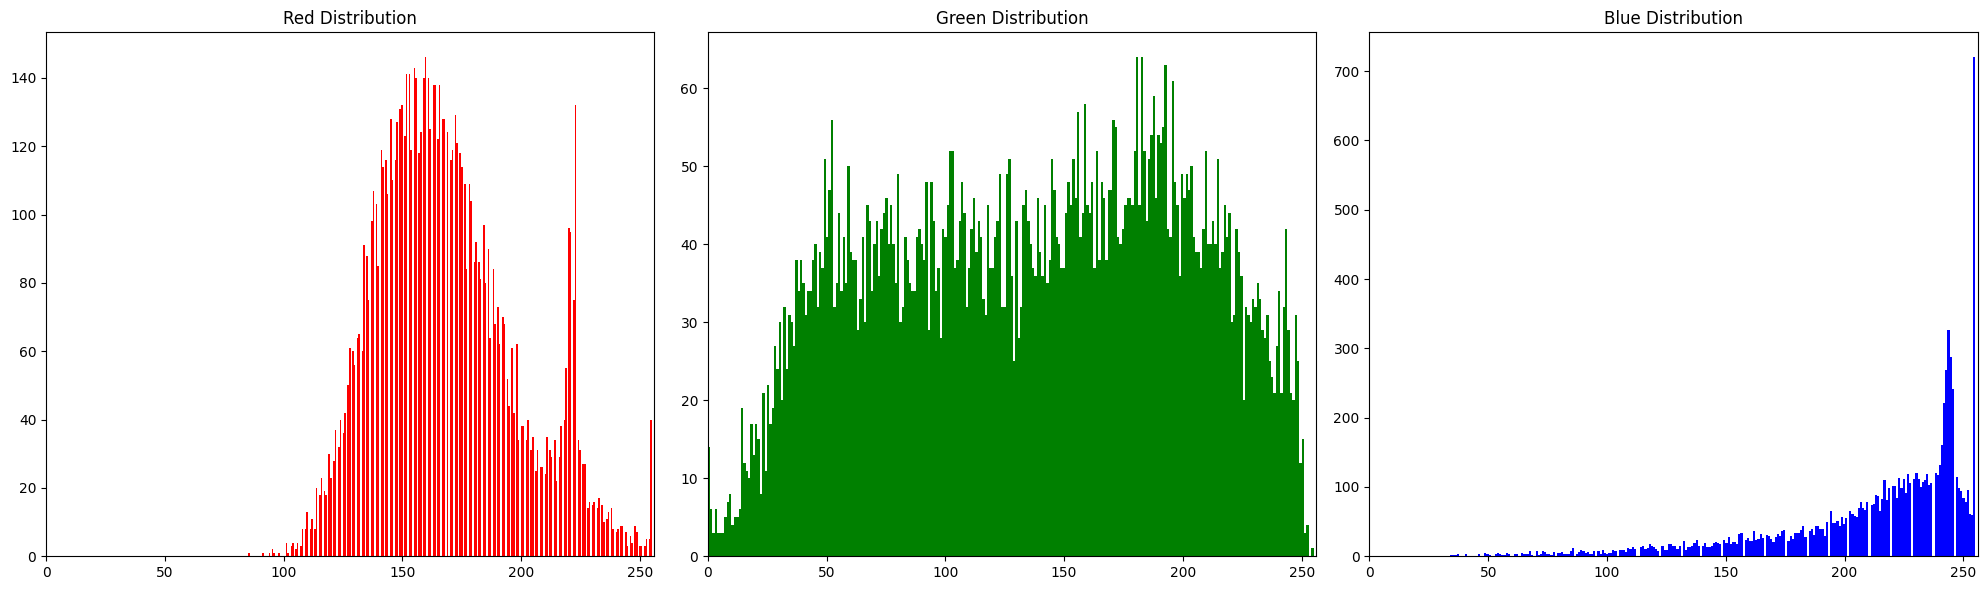

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i, color in enumerate(['Red', 'Green', 'Blue']):
    img = cv2.imread(os.path.join(datadir, 'train', f"{labels_df['id'].sample(1000).values[0]}.tif"))
    color_channel = img[:, :, i]
    ax[i].hist(color_channel.ravel(), bins=256, color=color.lower())
    ax[i].set_title(f"{color} Distribution")
    ax[i].set_xlim([0, 256])
plt.tight_layout()
plt.show()

Based on the sample and color data, each image seems to have a similar set of features and colors. Each one has blobs, light/dark spots, etc. There is no way we can differentiate the differences between the classes visually.

## Model Architecture

Given the dataset's substantial size (>7GB), it's crucial to take some steps to keep training optimized, one example is to process the images in batches during training to manage memory and computational efficiency.

Batch normalization can help to accelerate training and stabilize the learning process.

Dropout randomly sets a fraction of input units to 0 during training, which helps to prevent overfitting.

In [27]:
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 0.001

with tf.device('/gpu:0'):
    model = Sequential()

    # Images are 96x96 pixels with 3 color channels
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3), kernel_initializer="he_normal"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer="he_normal"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu', kernel_initializer="he_normal"))
    model.add(Dropout(0.5))
    # Binary classification
    model.add(Dense(1, activation='sigmoid', kernel_initializer="he_normal"))

    model.build((None, 96, 96, 3))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 96, 96, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 dropout_11 (Dropout)        (None, 94, 94, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_5 (Batc  (None, 47, 47, 32)       128       
 hNormalization)                                                 
                                                      

### Data Preparation

Before training the model, we need to preprocess and prepare the dataset.

In [28]:
labels_df_prepared = labels_df.copy()
labels_df_prepared['path'] = datadir + '/train/' + labels_df['id'] + ".tif"

def decode_img(img):
    img_array = imageio.imread(img.numpy())
    return tf.convert_to_tensor(img_array, dtype=tf.float32)

def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.py_function(decode_img, [img], tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, [96, 96])
    img /= 255.0
    return img, label

def load_data():
    dataset = tf.data.Dataset.from_tensor_slices((labels_df_prepared['path'].values, labels_df_prepared['label'].values))
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(2000).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    gc.collect()
    return dataset

### Model Training

Early stopping halts the training when training has stopped improving.

Adjusting the learning rate during training by reducing it if and when the validation score plateaus can be beneficial.

In [29]:
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

history = model.fit(
    load_data(),
    steps_per_epoch=BATCH_SIZE*2,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    epochs=EPOCHS)

Epoch 1/10


2023-09-11 05:20:37.874960: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_11/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


128/128 [==============================] - ETA: 0s - loss: 0.9095 - accuracy: 0.7258 - auc: 0.7807
Epoch 1: loss improved from inf to 0.90946, saving model to best_model.h5
128/128 [==============================] - 32s 191ms/step - loss: 0.9095 - accuracy: 0.7258 - auc: 0.7807 - lr: 0.0010
Epoch 2/10
128/128 [==============================] - ETA: 0s - loss: 0.5230 - accuracy: 0.7793 - auc: 0.8419
Epoch 2: loss improved from 0.90946 to 0.52301, saving model to best_model.h5
128/128 [==============================] - 25s 194ms/step - loss: 0.5230 - accuracy: 0.7793 - auc: 0.8419 - lr: 0.0010
Epoch 3/10
128/128 [==============================] - ETA: 0s - loss: 0.4479 - accuracy: 0.8105 - auc: 0.8726
Epoch 3: loss improved from 0.52301 to 0.44789, saving model to best_model.h5
128/128 [==============================] - 24s 188ms/step - loss: 0.4479 - accuracy: 0.8105 - auc: 0.8726 - lr: 0.0010
Epoch 4/10
128/128 [==============================] - ETA: 0s - loss: 0.4310 - accuracy: 0.811

## Results and Analysis 

In [31]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

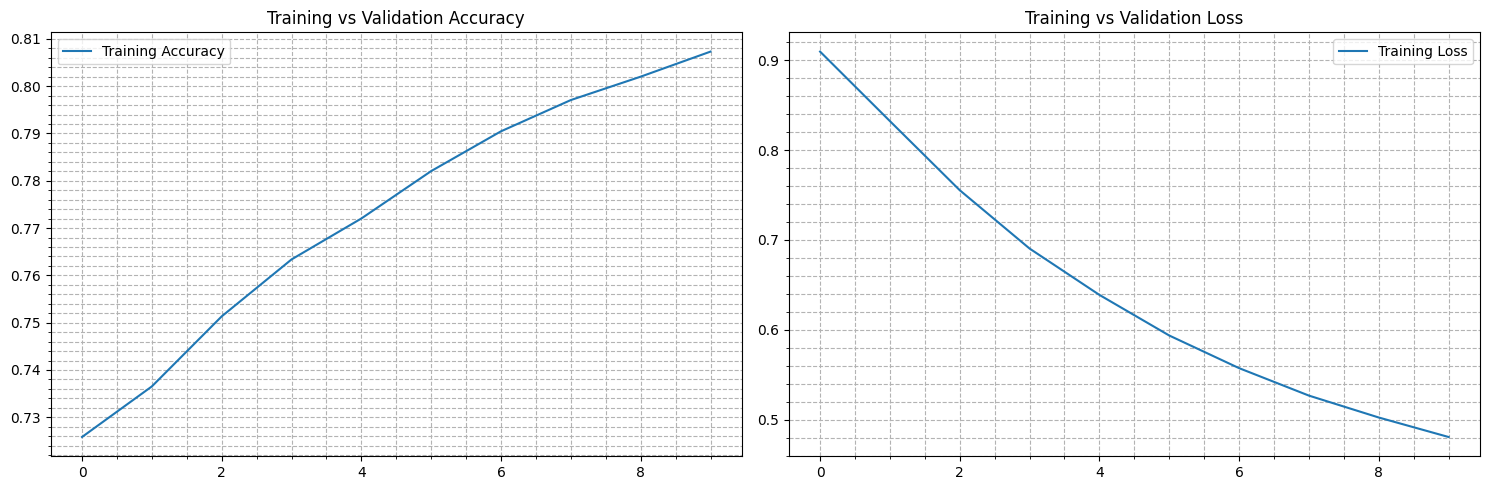

In [32]:
plt.figure(figsize=(15, 5))

# Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(smooth_curve(history.history['accuracy']), label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(smooth_curve(history.history['val_accuracy']), label='Validation Accuracy', alpha=0.6)
plt.legend()
plt.grid(True, which="both", ls="--", c='0.7')
plt.minorticks_on()
plt.title('Training vs Validation Accuracy')

# Training Loss
plt.subplot(1, 2, 2)
plt.plot(smooth_curve(history.history['loss']), label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(smooth_curve(history.history['val_loss']), label='Validation Loss', alpha=0.6)
    # Annotating the point of minimum validation loss
    min_val_loss_index = np.argmin(history.history['val_loss'])
    plt.scatter(min_val_loss_index, history.history['val_loss'][min_val_loss_index],
                color='red', marker='*', label=f'Min Val Loss at epoch {min_val_loss_index}')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.7')
plt.minorticks_on()
plt.title('Training vs Validation Loss')

plt.tight_layout()
plt.show()

## Submission

In [34]:
loaded_model = load_model('best_model.h5')

test_dir = os.path.join(datadir, 'test') 
test_image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.tif')]

def process_path_for_prediction(file_path):
    img = tf.io.read_file(file_path)
    img = tf.py_function(decode_img, [img], tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, [96, 96])
    img /= 255.0
    return img

def get_test_data():
    test_dataset = tf.data.Dataset.from_tensor_slices(test_image_paths)
    test_dataset = test_dataset.map(process_path_for_prediction, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE)
    gc.collect()
    return test_dataset

predictions = loaded_model.predict(get_test_data())

ids = [os.path.basename(path).replace('.tif', '') for path in test_image_paths]

submission_df = pd.DataFrame({
    'id': ids,
    'label': predictions.squeeze()
})

submission_df.to_csv('submission.csv', index=False)

898/898 [==============================] - 247s 275ms/step


## Conclusion

Throughout this project, I devoted considerable effort to refining the model and meticulously enhancing its architecture.

The Convolutional Neural Network (CNN) model I developed exhibited excellent convergence, ensuring a smooth and efficient training process.

Upon submitting the predictions, the scores I received were as follows:

**Private Score:** 0.8354  
**Public Score:** 0.8943

These results not only met my expectations but also positioned me within the top 1000 participants. Considering the competitive nature of such competitions, this is a great achievement.

However, reflection on this journey indicates potential avenues for improvement. Some strategies that could further elevate the model's performance include:

- **Extended Training Duration**: Time constraints limited the number of epochs I could run. A more extended training duration, I believe, could inch my scores closer to a 0.9 mark.
  
- **Innovative Model Architectures**: Delving deeper into more advanced and intricate model architectures could potentially unlock better feature extraction and predictions.

- **Dataset Equilibrium**: A balanced dataset, ensuring equal representation of classes, can often lead to better generalization and fewer biases in predictions. Fine-tuning the data distribution could yield even more accurate results.

In conclusion, while the results are commendable, the potential for improvement always exists. This project has been both a learning curve and an inspiration to delve deeper into the nuances of neural networks and image classification.